In [213]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import IPython.display as display
import os

from classes import *
from tqdm import tqdm
from utils import *

from pyswip import Prolog
from typing import List, Tuple

# fix the seed for reproducibility (not fixing the seed for the whole program since we have imports!)
random.seed(6667)
np.random.seed(6667)

# minihack env creation with a .des file

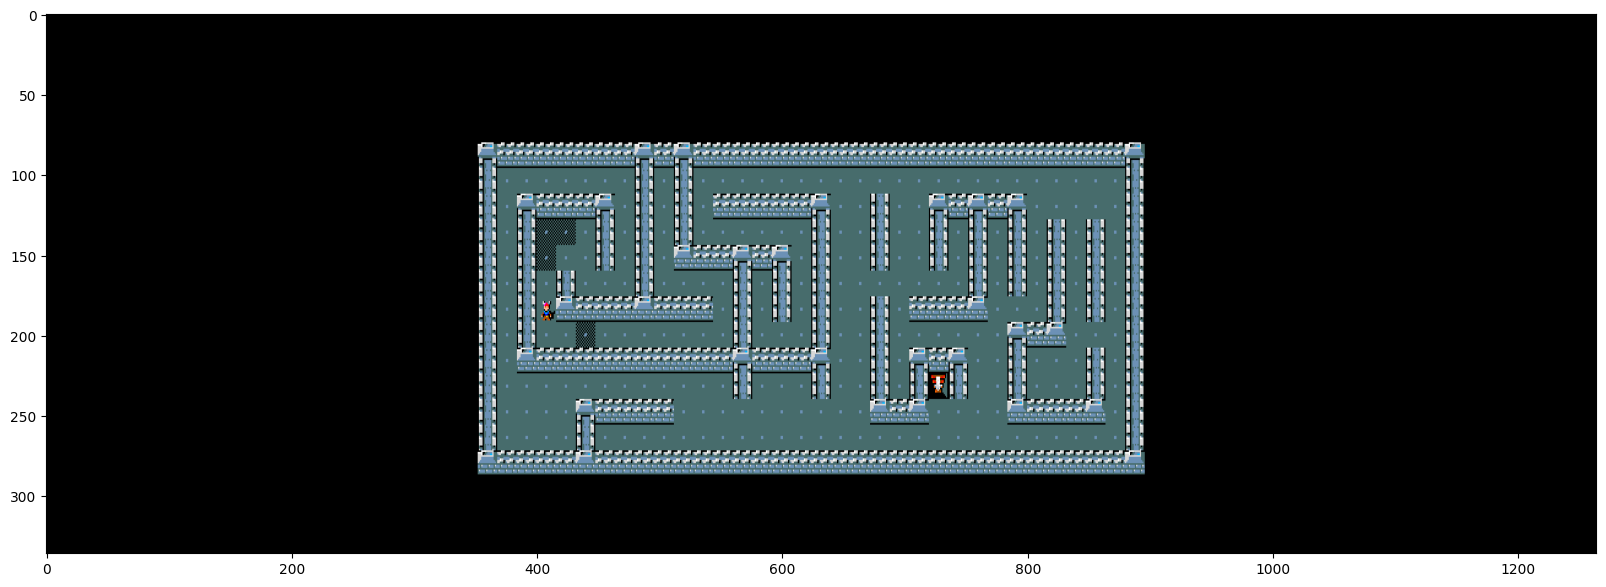

In [215]:
plt.rcParams["figure.figsize"] = [20, 7]
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file="maps/irene.des",
    max_episode_steps=10000,
)
state = env.reset()
# env.render()
plt.imshow(state["pixel"], aspect="auto")  # type: ignore

In [216]:
state = env.reset()
game_map = state["chars"]  # type: ignore
game = state["pixel"]  # type: ignore
start = get_player_location(game_map)
target = get_target_location(game_map)
game_map = Map(game_map, start, target)

> start: (11, 25), target: (14, 45)
> map size: (21, 79)


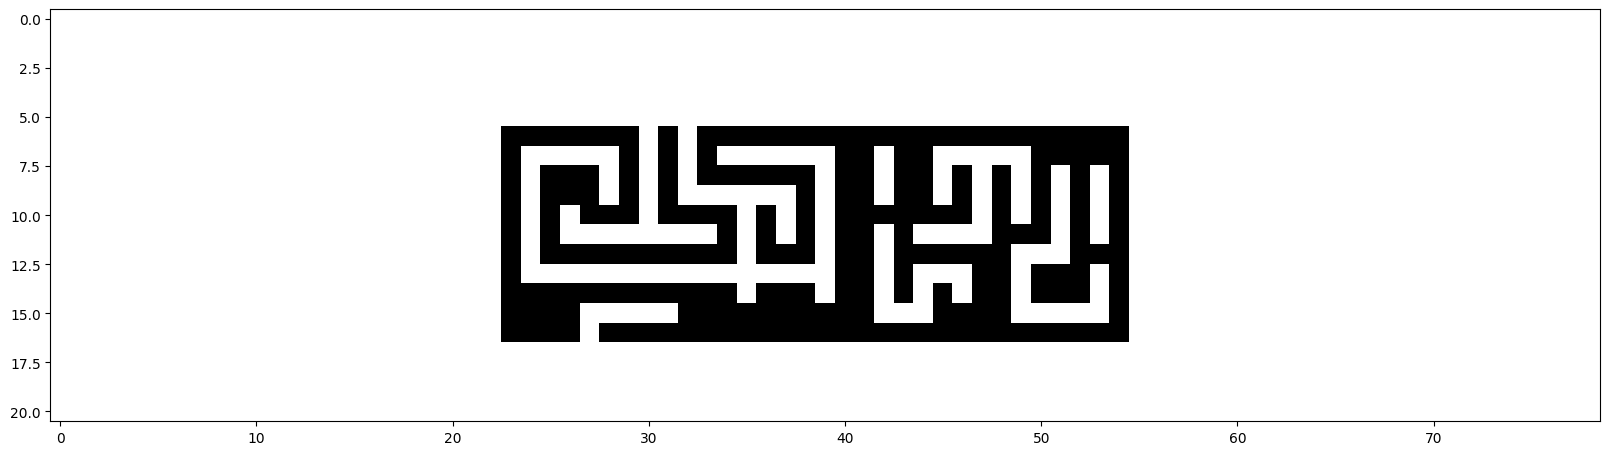

In [217]:
print(f"> start: {game_map.start}, target: {game_map.target}")
print(f"> map size: {game_map.layout.shape}")
# print the map_matrix with matplotlib where the walls are black and the floor is white
plt.imshow(game_map.map_matrix, cmap="gray")
plt.show()

In [218]:
PATH = "kb/kb.pl"
KB = Prolog()
KB.consult(PATH)

KB.retractall("maze(_)")
KB.retractall("start(_,_)")
KB.asserta(f"maze({game_map.map_matrix})")
KB.asserta(f"start({game_map.start[0]}, {game_map.start[1]})")

for i in KB.query("maze(X)"):
    print(f'{i["X"]}\n')  # type: ignore

# list(KB.query("maze(X)"))

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

# NTH1

In Prolog, `nth1/3` is a built-in predicate that is used to access elements in a list by index. The `nth1/3` predicate has the following form:

```prolog
nth1(Index, List, Element)
```
Index: The index of the element you want to access.

List: The list from which you want to access the element.

Element: The variable that will be unified with the element at the specified index.


In [219]:
result = list(KB.query("maze(M), nth1(14, M, Row), nth1(23, Row, Cell)"))
if result:
    cell_value = result[0]["Cell"]  # type: ignore
    print(f"Cell value: {cell_value}")
else:
    print("Query result is empty.")

Cell value: 1


In [220]:
list(KB.query("start(ROW,COL)"))

[{'ROW': 11, 'COL': 25}]

In [221]:
list(KB.query(f"is_valid(10,23)"))

[]

In [222]:
list(KB.query(f"is_valid(9,23)"))

[]

In [223]:
solution = list(KB.query(f"is_valid(14,23)"))
if solution:
    print("Position is valid.")
else:
    print("Position is not valid.")

Position is not valid.


In [224]:
list(KB.query(f"is_valid_action(11,23,0)"))

[]

In [225]:
list(KB.query(f"is_valid_action(10,23,0)"))

[]

# We have to decide if we want to generate a random path or random actions

random path $\Rightarrow$ a path of exactly n steps

random actions $\Rightarrow$ many action will be not valid $\Rightarrow$ the path will be shorter OR, as is implemented now, with many repetition of the same position.

# NOTE:
minihack wont crash if we input a not valid action starting from a valid action. It will simply not execute the action (as if we are playing), hence we are updating the path position with the same position.

In [226]:
actions = random_nactions(300)
path = path_from_actions(game_map.layout, game_map.start, actions)
i = Individual(actions, 0, game_map)

In [227]:
# create first generation
MAX_GENERATIONS = 500
MAX_INDIVIDUALS = 8
EXPERIMENTS = 100

In [228]:
# create first generation
MAX_GENERATIONS = 600
MAX_INDIVIDUALS = 24

best_individuals = []

print("> Creating initial population...")
individuals = [
    Individual(random_nactions(300), 1, game_map) for _ in range(MAX_INDIVIDUALS)
]
individuals.sort(key=lambda x: x.fitness, reverse=True)
print("> Evolving...")

with tqdm(total=MAX_GENERATIONS, colour='#9244c9', ncols=150) as pbar:
    for generation in range(MAX_GENERATIONS):
        best_fitness = individuals[0].fitness
        best_individuals.append(individuals[0])
        if generation % 25 == -1:
            print(
                format_loop.format(
                    generation,
                    best_fitness,
                    individuals[0].wrong_actions,
                    individuals[0].loops,
                    individuals[0].dead_ends,
                    individuals[0].distance,
                )
            )

        # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
        # also roulette wheel selection.
        p1, p2 = individuals[0], individuals[1]
        errors = p1.error_vector + p2.error_vector

        offspring = [
            softmax_mutate(
                crossover(p1.actions, p2.actions), errors, generation=generation
            )
            for _ in range(MAX_INDIVIDUALS)
        ]

        individuals[2:] = [
            Individual(offspring[i], generation + 1, game_map)
            for i in range(MAX_INDIVIDUALS - 2)
        ]
        individuals.sort(key=lambda x: x.fitness, reverse=True)

        if individuals[0].fitness == 0:
            print(
                f"> best individual in generation {generation}: {individuals[0].fitness}, wrong actions: {individuals[0].wrong_actions}"
            )
            break

        pbar.set_postfix(
            best_fitness=best_fitness, 
            distance=individuals[0].distance, 
            dead_ends=individuals[0].dead_ends, 
            loops=individuals[0].loops, 
            wrong_actions=individuals[0].wrong_actions,
            refresh=False
        )
        
        pbar.update(1)

best_fitness = individuals[0].fitness
best_individuals.append(individuals[0])

> Creating initial population...
> Evolving...


 31%|███▏      | 188/600 [00:19<00:43,  9.49it/s, best_fitness=-3, dead_ends=0, distance=3, loops=217, wrong_actions=139]  

> best individual in generation 188: 0, wrong actions: 142


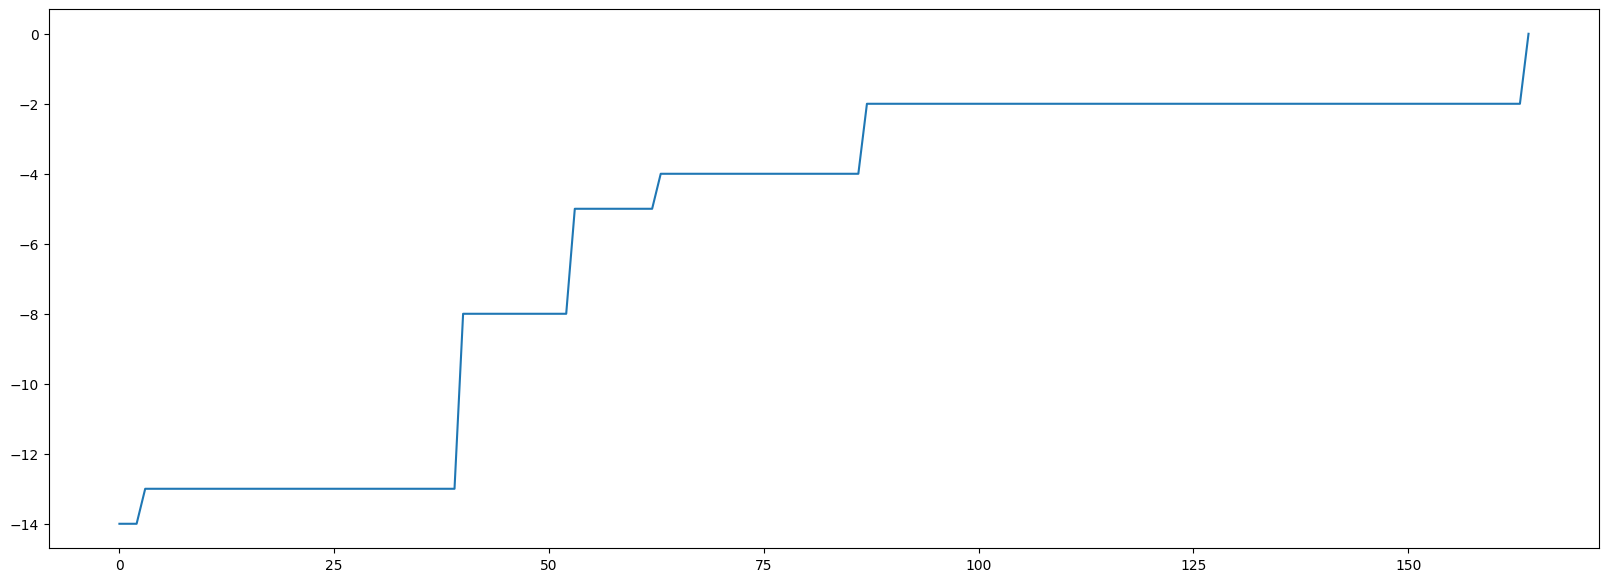

In [166]:
# Plot for each generation the best fitness
best_fitness = [best_individuals[i].fitness for i in range(len(best_individuals))]
plt.plot(best_fitness)

YOU WON! <3


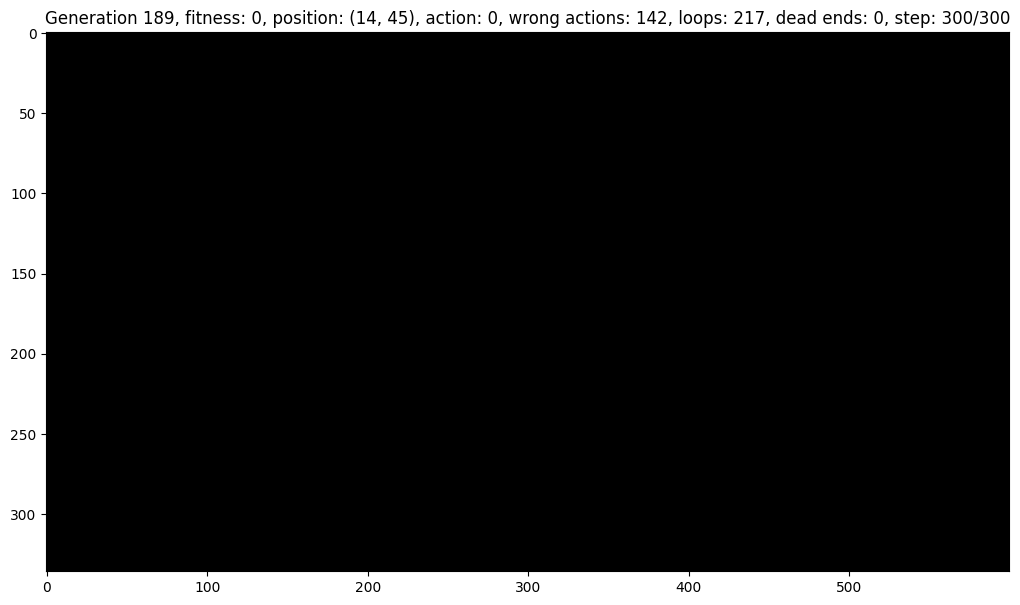

In [137]:
env.reset()
plt.rcParams["figure.figsize"] = [18, 7]

image = plt.imshow(game[:, 300:900])
# for generation, path in enumerate(best_paths):
# plt.title(f"Generation {generation}, fitness: {best_scores[generation]:.2f}, last move: {path[-1]}")
# start = best_paths[0]
# path = best_paths[-1]
actions = []
actions = individuals[0].actions
wrong = 0

for i, action in enumerate(actions):
    try:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.title(
            format_title.format(
                individuals[0].generation,
                individuals[0].fitness,
                individuals[0].path[i],
                action,
                wrong,
                individuals[0].loops,
                individuals[0].dead_ends,
                i + 1,
                len(actions),
            )
        )
        image.set_data(s["pixel"][:, 300:900])
        # time.sleep(0.1)
        if individuals[0].path[i] == game_map.target:
            print("YOU WON! <3")
            break
        if individuals[0].path[i] == individuals[0].path[i - 1]:
            wrong += 1
    except RuntimeError:
        print("YOU WON! <3")